In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
import os

os.chdir("/content/gdrive/MyDrive/Bundletrack++/bundletrack_process_depth")
!nvidia-smi

Mounted at /content/gdrive/
Wed Jul 12 20:27:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |   6489MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

# Depth

In [ ]:
# !pip install moviepy
# !pip install timm

In [ ]:
# convert video to frames
video_path = "4016_toss1.mov"
frames_folder = "frames/"

from moviepy.editor import VideoFileClip
import cv2
from tqdm import tqdm

# Create the destination folder if it doesn't exist
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

# Load the video clip
clip = VideoFileClip(video_path)

# Iterate through each frame in the video
for i, frame in tqdm(enumerate(clip.iter_frames())):
    # Construct the frame filename
    frame_filename = os.path.join(frames_folder, f"frame_{i}.png")

    # Convert the frame to RGB format (if necessary)
    if frame.ndim == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Save the frame as a JPEG image
    cv2.imwrite(frame_filename, frame)


1618it [04:55,  5.52it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file 4016_toss1.mov, 6220800 bytes wanted but 0 bytes read,at frame 1618/1619, at time 53.93/53.95 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

1619it [04:56,  5.47it/s]


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load pretrained depth estimator network
model_type = 'DPT_Large'
depth_estimator = torch.hub.load("intel-isl/MiDaS", model_type)
depth_estimator.to(device)
depth_estimator.eval();

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
fig = plt.figure(figsize=(6, 4))

image_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.CenterCrop(size=(1080, 1440)),
     transforms.Resize(size=(480, 640))]
)

# load all images in dataset
source_folder = "frames/"
destination_folder = "depths/"

image_paths = []
for filename in os.listdir(source_folder):
    image_paths.append(filename)

with torch.no_grad():
    for image_path in tqdm(image_paths):
        load_path = os.path.join(source_folder, image_path)
        image = Image.open(load_path)

        # convert PIL Image to PyTorch tensor
        image = image_transform(image).to(device)
        image = torch.unsqueeze(image, dim=0)

        # estimate the depth map from each image
        image_depth = depth_estimator(image)  # size (1, 3, 256, 256)
        image_depth = 1000 * image_depth / (torch.max(image_depth) - torch.min(image_depth))

        # save depth maps
        image_depth = image_depth[0].cpu().numpy().astype(np.uint16)
        image_depth = Image.fromarray(image_depth)

        id = image_path.split("_")[1].split(".")[0]
        padded_id = id.zfill(4)
        save_name = str(padded_id)+'.png'
        save_path = os.path.join(destination_folder, save_name)
        image_depth.save(save_path)

        # # show depth maps
        # plt.imshow(image[0].permute(1, 2, 0).cpu())
        # plt.show()
        # plt.imshow(image_depth)
        # plt.show()
        # break


  0%|          | 0/1619 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(

100%|██████████| 1619/1619 [11:51<00:00,  2.28it/s]


<Figure size 600x400 with 0 Axes>

# Mask

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
import numpy as np
from torchvision import models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import torchvision.transforms as transforms

class CubeDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.to_tensor = transforms.ToTensor()
        self.transform = transforms.Compose(
                            [transforms.ToTensor(),
                            transforms.Resize(size=(480, 640))]
                         )
        self.mask_names = os.listdir(mask_dir)

    def __len__(self):
        return len(self.mask_names)

    def __getitem__(self, idx):
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])
        mask = torch.squeeze(self.to_tensor(Image.open(mask_path).convert("L")), dim=0)
        mask[mask == 255.0] = 1.0

        # Format the frame name
        try:
            frame_number = int(self.mask_names[idx].split('.')[0])
        except:
            return None, None
        new_frame_number = f'frame_{frame_number}.png'

        img_path = os.path.join(self.img_dir, new_frame_number)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        # print('mask_path', mask_path, mask.shape, 'img_path', img_path, image.shape)

        return image, mask

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    for i, (X, y) in enumerate(tqdm(dataloader)):
        bs = len(y)
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        preds, targets = preds['out'].view(-1), y.view(-1)

        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if i % 100 == 0:
          print('loss', loss.item())

    return epoch_loss / len(dataloader)

def test_model(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            loss = criterion(preds, y)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)


# Prepare data
train_data = CubeDataset('frames', 'masks')
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

# Prepare model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = models.segmentation.fcn_resnet50(weights=False, num_classes=1).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Train and test model
for epoch in range(3):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    scheduler.step()
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss}')


  0%|          | 1/1618 [00:00<15:42,  1.72it/s]

loss 0.639696478843689


  6%|▌         | 101/1618 [00:36<08:46,  2.88it/s]

loss 0.006948824040591717


 12%|█▏        | 201/1618 [01:13<09:42,  2.43it/s]

loss 0.0038141768891364336


 19%|█▊        | 301/1618 [01:51<08:22,  2.62it/s]

loss 0.005756949074566364


 25%|██▍       | 401/1618 [02:28<07:44,  2.62it/s]

loss 0.004314035642892122


 31%|███       | 501/1618 [03:06<07:07,  2.61it/s]

loss 0.0067081572487950325


 37%|███▋      | 601/1618 [03:43<06:30,  2.60it/s]

loss 0.002224305644631386


 43%|████▎     | 701/1618 [04:22<05:37,  2.71it/s]

loss 0.002094028750434518


 50%|████▉     | 801/1618 [05:00<04:50,  2.81it/s]

loss 0.0019022630294784904


 56%|█████▌    | 901/1618 [05:37<04:51,  2.46it/s]

loss 0.002114379545673728


 62%|██████▏   | 1001/1618 [06:13<03:36,  2.85it/s]

loss 0.002544223563745618


 68%|██████▊   | 1101/1618 [06:50<03:04,  2.81it/s]

loss 0.002526653464883566


 74%|███████▍  | 1201/1618 [07:27<02:47,  2.49it/s]

loss 0.0036193402484059334


 80%|████████  | 1301/1618 [08:04<01:52,  2.81it/s]

loss 0.0017187794437631965


 87%|████████▋ | 1401/1618 [08:41<01:15,  2.88it/s]

loss 0.001689781784079969


 93%|█████████▎| 1501/1618 [09:17<00:42,  2.74it/s]

loss 0.0018142976332455873


 99%|█████████▉| 1601/1618 [09:54<00:06,  2.76it/s]

loss 0.0014496995136141777


100%|██████████| 1618/1618 [10:00<00:00,  2.69it/s]


Epoch: 1, Train Loss: 0.008868569497474353


  0%|          | 1/1618 [00:00<10:36,  2.54it/s]

loss 0.001438906416296959


  6%|▌         | 101/1618 [00:37<09:06,  2.77it/s]

loss 0.001461331732571125


 12%|█▏        | 201/1618 [01:15<08:47,  2.69it/s]

loss 0.0015875243116170168


 19%|█▊        | 301/1618 [01:53<08:22,  2.62it/s]

loss 0.00395663408562541


 25%|██▍       | 401/1618 [02:30<07:17,  2.78it/s]

loss 0.0026291748508810997


 31%|███       | 501/1618 [03:08<06:50,  2.72it/s]

loss 0.004465051461011171


 37%|███▋      | 601/1618 [03:45<06:24,  2.64it/s]

loss 0.0011490113101899624


 43%|████▎     | 701/1618 [04:23<06:02,  2.53it/s]

loss 0.0010806763311848044


 50%|████▉     | 801/1618 [05:00<05:36,  2.43it/s]

loss 0.005085333716124296


 56%|█████▌    | 901/1618 [05:38<04:23,  2.73it/s]

loss 0.0011597416596487164


 62%|██████▏   | 1001/1618 [06:15<03:37,  2.83it/s]

loss 0.002490389859303832


 68%|██████▊   | 1101/1618 [06:53<03:13,  2.67it/s]

loss 0.003579087322577834


 74%|███████▍  | 1201/1618 [07:30<02:29,  2.80it/s]

loss 0.0016797080170363188


 80%|████████  | 1301/1618 [08:07<01:52,  2.82it/s]

loss 0.001025880454108119


 87%|████████▋ | 1401/1618 [08:45<01:21,  2.68it/s]

loss 0.0019108264241367579


 93%|█████████▎| 1501/1618 [09:23<00:43,  2.69it/s]

loss 0.0016418789746239781


 99%|█████████▉| 1601/1618 [10:01<00:06,  2.62it/s]

loss 0.0017840759828686714


100%|██████████| 1618/1618 [10:08<00:00,  2.66it/s]


Epoch: 2, Train Loss: 0.0022905680679555576


  0%|          | 1/1618 [00:00<09:28,  2.84it/s]

loss 0.004603585693985224


  6%|▌         | 101/1618 [00:37<09:34,  2.64it/s]

loss 0.0028970984276384115


 12%|█▏        | 201/1618 [01:15<08:56,  2.64it/s]

loss 0.0030072478111833334


 19%|█▊        | 301/1618 [01:53<07:51,  2.79it/s]

loss 0.0010477177565917373


 25%|██▍       | 401/1618 [02:31<07:40,  2.64it/s]

loss 0.001719523686915636


 31%|███       | 501/1618 [03:09<07:54,  2.35it/s]

loss 0.0011036510113626719


 37%|███▋      | 601/1618 [03:46<06:33,  2.59it/s]

loss 0.0009079178562387824


 43%|████▎     | 701/1618 [04:23<05:34,  2.74it/s]

loss 0.0010337157873436809


 50%|████▉     | 801/1618 [05:00<04:59,  2.73it/s]

loss 0.0029580348636955023


 56%|█████▌    | 901/1618 [05:37<04:10,  2.86it/s]

loss 0.0007893901201896369


 62%|██████▏   | 1001/1618 [06:14<03:49,  2.69it/s]

loss 0.0034846391063183546


 68%|██████▊   | 1101/1618 [06:51<03:11,  2.70it/s]

loss 0.001852514804340899


 74%|███████▍  | 1201/1618 [07:28<02:30,  2.77it/s]

loss 0.0025458489544689655


 80%|████████  | 1301/1618 [08:05<02:12,  2.40it/s]

loss 0.0008052397752180696


 87%|████████▋ | 1401/1618 [08:42<01:20,  2.69it/s]

loss 0.0008322703652083874


 93%|█████████▎| 1501/1618 [09:19<00:41,  2.83it/s]

loss 0.0018109347438439727


 99%|█████████▉| 1601/1618 [09:56<00:06,  2.72it/s]

loss 0.0009368127794004977


100%|██████████| 1618/1618 [10:02<00:00,  2.69it/s]

Epoch: 3, Train Loss: 0.0014651236440197822


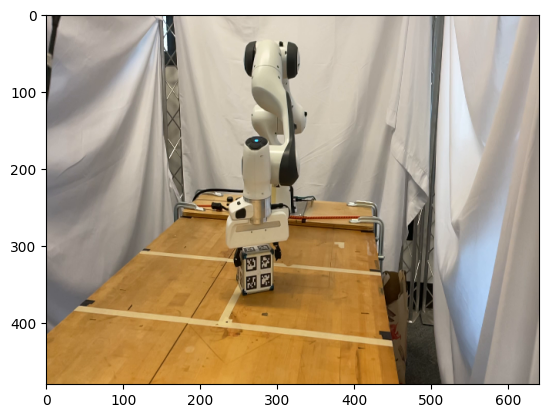

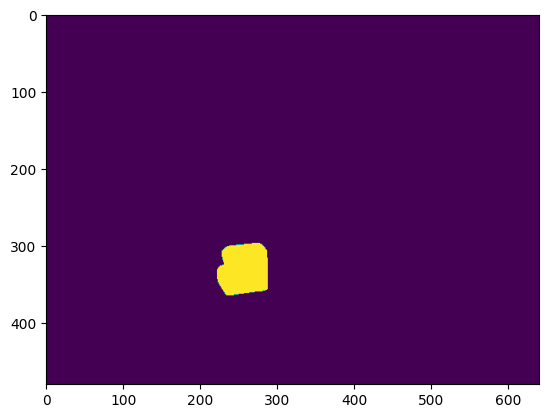

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

transform = transforms.Compose(
              [transforms.ToTensor(),
              transforms.Resize(size=(480, 640))]
            )

img_path = os.path.join('frames', 'frame_110.png')
image = Image.open(img_path).convert("RGB")
image = transform(image)

model.eval()
with torch.no_grad():
    image = image.to(device)
    preds = model(torch.unsqueeze(image, dim=0))['out']

preds = F.sigmoid(preds[0][0])
preds[preds < 0.5] = 0
preds[preds >= 0.5] = 1

plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.show()
plt.imshow(preds.cpu().numpy())
plt.show()

In [ ]:
torch.save(model, 'mask_fcn.pt')
# https://drive.google.com/file/d/1-3YINzCwXbdaf4q_WWo-upKqkwpCJQaB/view?usp=share_link